### TRMM PNG monitoring

In [58]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
from mpl_toolkits.basemap import maskoceans, interp

In [59]:
import numpy as np
import pandas as pd
import xray
from netCDF4 import MFDataset
from datetime import datetime, timedelta
from glob import glob
import palettable

In [60]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [61]:
dpath = '/Users/nicolasf/data/TRMM/daily/'
climpath = '/Users/nicolasf/data/TRMM/climatology/daily/'

In [62]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xray.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    #paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in files]
    combined = xray.concat(datasets, dim)
    return combined

### set up the domain 

In [63]:
domain = {'latmin':-12., 'lonmin':140., 'latmax':0., 'lonmax':160.}

### original resolution of the dataset

In [64]:
res = 0.25 

### factor by which the resolution will be increased

In [65]:
interp_factor = 10

### set up the map

In [66]:
m = bm(projection='cyl', llcrnrlon=domain['lonmin']+0.25, \
              llcrnrlat=domain['latmin']+0.25, \
              urcrnrlon=domain['lonmax']-0.25, \
              urcrnrlat=domain['latmax']-0.25, resolution='f')

In [204]:
today = datetime.utcnow()

In [205]:
today

datetime.datetime(2015, 10, 20, 1, 39, 19, 112001)

### lag is the lag in days

In [250]:
lag = 2

### ndays is the number of days to retrieve (i.e. last 30 days, last 60 days, etc)

In [251]:
ndays = 90

### get the current TRMM date

In [252]:
trmm_date = today - timedelta(days=lag)

In [253]:
trmm_date

datetime.datetime(2015, 10, 18, 1, 39, 19, 112001)

### creates the list of days 

In [254]:
realtime = pd.date_range(start=trmm_date - timedelta(days=ndays-1), end=trmm_date)

In [255]:
print("calculating realtime data for {:%Y-%m-%d} to {:%Y-%m-%d}".format(realtime[0], realtime[-1]))

calculating realtime data for 2015-07-21 to 2015-10-18


In [256]:
lfiles = []
for d in realtime: 
    fname  = dpath + "3B42RT_daily.{}.nc".format(d.strftime("%Y.%m.%d"))
    lfiles.append(fname)

### reads the files

In [257]:
dset_realtime = read_netcdfs(lfiles, 'time')

In [258]:
dset_realtime

<xray.Dataset>
Dimensions:  (lat: 240, lon: 420, time: 90)
Coordinates:
  * lon      (lon) float32 135.125 135.375 135.625 135.875 136.125 136.375 ...
  * lat      (lat) float32 -49.875 -49.625 -49.375 -49.125 -48.875 -48.625 ...
  * time     (time) datetime64[ns] 2015-07-21 2015-07-22 2015-07-23 ...
Data variables:
    trmm     (time, lat, lon) float64 2.64 2.4 2.04 2.19 3.33 3.78 2.43 1.92 ...
Attributes:
    title: saved netcdf variable

### selects the domain

In [259]:
dset_realtime = dset_realtime.sel(lat=slice(domain['latmin'], domain['latmax']), \
                                  lon=slice(domain['lonmin'], domain['lonmax']))

### reads the climatology

In [260]:
clim_files = []
for d in realtime: 
    fname  = climpath + "3B42_daily.{}.nc".format(d.strftime("%m.%d"))
    clim_files.append(fname)

In [261]:
dset_clim = read_netcdfs(clim_files, 'time')

### selects the domain

In [262]:
dset_clim = dset_clim.sel(latitude=slice(domain['latmin'], domain['latmax']), \
                          longitude=slice(domain['lonmin'], domain['lonmax']))

### calculates the averages and cumulative rainfall

In [263]:
clim_ave = dset_clim.mean('time')
clim_sum = dset_clim.sum('time')

In [264]:
realtime_ave = dset_realtime.mean('time')
realtime_sum = dset_realtime.sum('time')

In [221]:
realtime_ave

<xray.Dataset>
Dimensions:  (lat: 48, lon: 80)
Coordinates:
  * lon      (lon) float32 140.125 140.375 140.625 140.875 141.125 141.375 ...
  * lat      (lat) float32 -11.875 -11.625 -11.375 -11.125 -10.875 -10.625 ...
Data variables:
    trmm     (lat, lon) float64 0.1117 0.123 0.109 0.06433 0.04 0.05467 ...

In [222]:
realtime_ave['clim'] = (['lat','lon'], clim_ave['hrf'].data)
realtime_sum['clim'] = (['lat','lon'], clim_sum['hrf'].data)

### calculates the anomalies

In [223]:
raw = realtime_sum['trmm']

In [224]:
anoms = realtime_sum['trmm'] - realtime_sum['clim']

In [225]:
anomsp = ((realtime_sum['trmm'] - realtime_sum['clim']) / realtime_sum['clim']) * 100.

In [226]:
pp = realtime_sum['trmm'] / realtime_sum['clim'] * 100.

### gets the cmap

In [227]:
cmap_anoms = palettable.colorbrewer.diverging.BrBG_11.mpl_colormap

### set up the dictionnary with the cities and their coordinates 

The coordinates can be viewed on geohack, follow the links on the right of the wikipedia page for the 
corresponding city

In [228]:
cities = {}
cities['Port Moresby'] = (-9.513639, 147.218806)
cities['Lae'] = (-6.73333, 147)
cities['Alotau'] = (-10.316667, 150.433333)
cities['Daru'] = (-9.083333, 143.2)
cities['Madang'] = (-5.216667, 145.8)
cities['Wewak'] = (-3.55, 143.633333)

In [229]:
def round_10(x, how='down'):
    import math
    if how == 'up': 
        return int(math.ceil(x / 10.0)) * 10
    elif how == 'down': 
        return int(math.floor(x / 10.0)) * 10

In [230]:
def plot_cities(ax, cities): 
    for k in cities: 
        ax.plot(cities[k][1],cities[k][0], 'ro', transform=ax.transData)
        ax.text(cities[k][1]+0.1,cities[k][0]+0.1, k, transform=ax.transData, \
                fontsize=14, color='#0B0B61')

In [231]:
def get_limits(Dataarray, robust=True, robust_percentile=2, center=None): 
        # ravel and removes nans for calculation of intervals etc
        calc_data = Dataarray.data
        calc_data = np.ravel(calc_data[np.isfinite(calc_data)])

        # the following is borrowed from xray
        # see: plot.py in xray/xray/plot
        vmin = np.percentile(calc_data, robust_percentile) if robust else calc_data.min()
        vmax = np.percentile(calc_data, 100 - robust_percentile) if robust else calc_data.max()

        del(calc_data)

        # Simple heuristics for whether these data should  have a divergent map
        divergent = ((vmin < 0) and (vmax > 0)) or center is not None

        # Now set center to 0 so math below makes sense
        if center is None:
            center = 0

        # A divergent map should be symmetric around the center value
        if divergent:
            vlim = max(abs(vmin - center), abs(vmax - center))
            vmin, vmax = -vlim, vlim

        # Now add in the centering value and set the limits
        vmin += center
        vmax += center
        
        vmin = round_10(vmin)
        if center == 0: 
            vmax = round_10(vmax, how='up')
        else: 
            vmax = round_10(vmax)
            
        
        step = round_10((vmax - vmin) / 12)

        return (vmin, vmax, step)

In [232]:
def plot_map(m, Dataarray, vmin=None, vmax=None, step=None, title="", units="", draw_cities=True, cmap=plt.get_cmap('Blues')): 
    
    lon = Dataarray.lon
    lat = Dataarray.lat
    
    nlats = interp_factor * len(lat)
    nlons = interp_factor * len(lon)
    
    lons = np.linspace(float(min(lon)),float(max(lon)),nlons)
    lats = np.linspace(float(min(lat)),float(max(lat)),nlats)
    
    lons, lats = np.meshgrid(lons, lats)
    
    offset = np.diff(lons)[0][0] / 2.

    x, y = m(lons-offset, lats-offset)
    
    if vmin is None or vmax is None or step is None: 
        vmin, vmax, step = get_limits(Dataarray)
        
    if ((vmin < 0) and (vmax > 0)): 
        ticks_range = list(np.arange(vmin, 0, step)) + list(np.arange(vmin, 0, step)[::-1]*-1)
        ticks_range = np.array(ticks_range)
    else: 
        ticks_range = np.arange(vmin, vmax+step, step)
            
    interp_array = interp(Dataarray.data,lon.data.flatten(),lat.data.flatten(),lons,lats,order=1)
    
    # interpolate land/sea mask to topo grid, mask ocean values.
    interp_array_m = maskoceans(lons, lats, interp_array, resolution='f', grid=1.25)
    # make contour plot (ocean values will be masked)
    
    f, ax = plt.subplots(figsize=(20,20 * np.divide(*interp_array_m.shape)))
    f.subplots_adjust(left=0.1)

    m.ax = ax
    m.drawcoastlines(color='k')
    m.drawcountries(linewidth=1)

    meridians = np.arange(140., 160., 5)
    parallels = np.arange(-10., 0., 2.5)

    m.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

    m.drawrivers(color='steelblue')

    im=m.pcolor(x,y,interp_array_m,cmap=cmap,vmin=vmin,vmax=vmax, snap=False)

    m.drawmapboundary(fill_color='steelblue')
    
    # add the copyright blob
    text = u'\N{Copyright Sign}' + ' PNG National Weather Service \n http://www.pngmet.gov.pg'
    ax.text(0.77,0.9275, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.5))
    
    # set up the colorbar
    cb = m.colorbar(im, location='right', \
                    ticks=ticks_range, \
                    size="3%", \
                    boundaries=ticks_range,\
                    drawedges=True)
    [l.set_fontsize(18) for l in cb.ax.get_yticklabels()]; 
    cb.set_label(units, fontsize=20)
    
    
    ax.set_title(title, fontsize=26)

    plot_cities(ax, cities)
    
    return f

### plots the long term climatology

In [233]:
title = 'TRMM / TMPA-RT 3B42RT Rainfall climatology (2000-2014) for the last {} days\n{:%B-%d} to {:%B-%d}'\
.format(ndays, realtime[0],realtime[-1])

In [234]:
vmin, vmax, step = get_limits(realtime_sum['clim'])

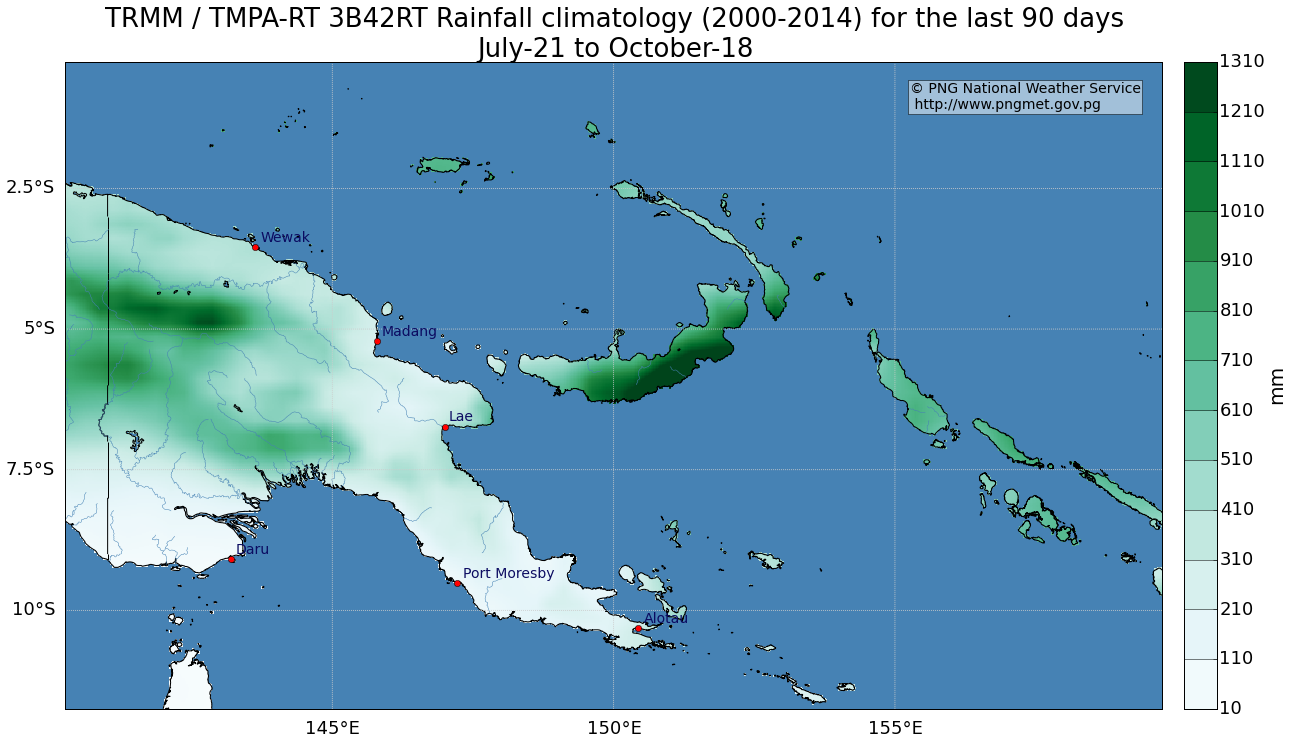

In [235]:
f = plot_map(m, realtime_sum['clim'], title=title, units="mm", draw_cities=True, cmap=plt.get_cmap('BuGn'))

In [236]:
f.savefig('../images/realtime_maskocean_CLIM_{}.png'.format(ndays), dpi=200)

### plots the last N days observed rainfall

In [237]:
title = 'TRMM / TMPA-RT 3B42RT observed rainfall for the last {} days\n{:%Y-%B-%d} to {:%Y-%B-%d}'\
.format(ndays, realtime[0],realtime[-1])

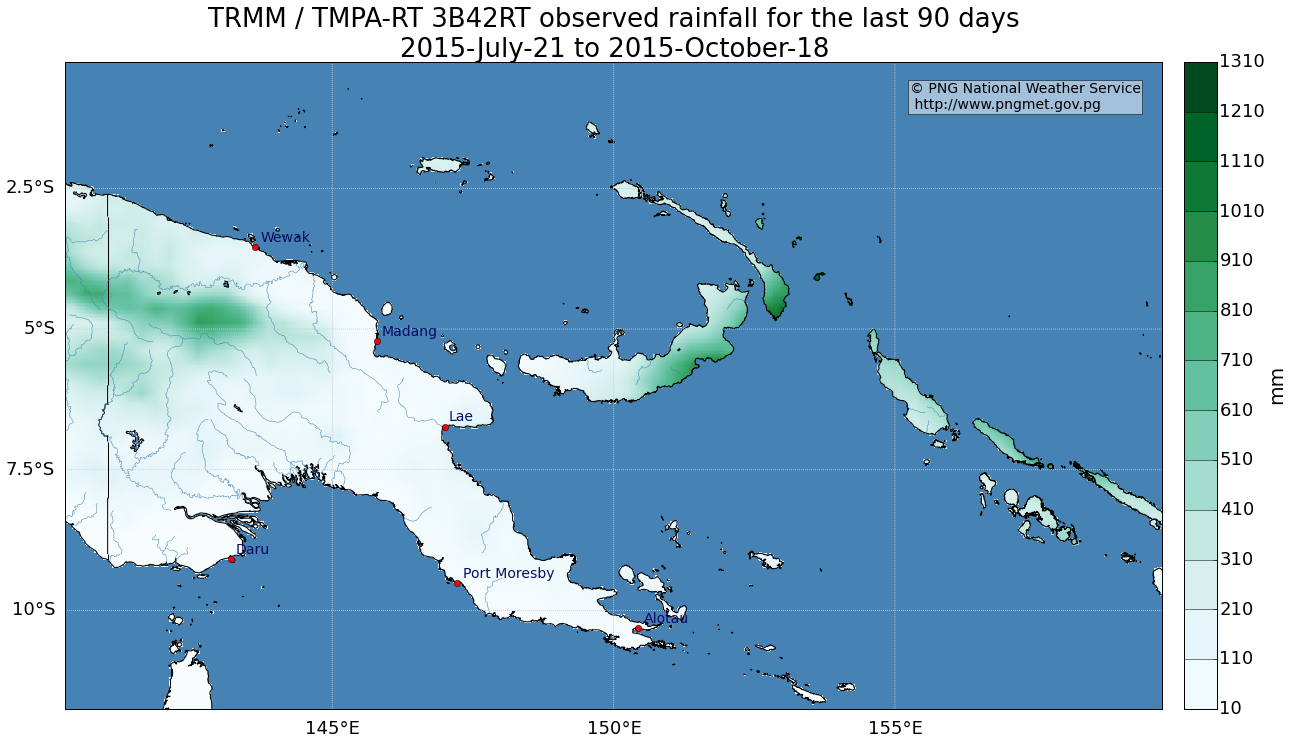

In [238]:
f = plot_map(m, raw, vmin=vmin, vmax=vmax, step=step, title=title, units='mm', draw_cities=True, cmap=plt.get_cmap('BuGn'))

In [239]:
f.savefig('../images/realtime_maskocean_OBS_{}.png'.format(ndays), dpi=200)

### plots the anomalies in mm

In [240]:
title = 'TRMM / TMPA-RT 3B42RT rainfall anomalies (mm) for the last {} days\n{:%Y-%B-%d} to {:%Y-%B-%d}'\
.format(ndays, realtime[0],realtime[-1])

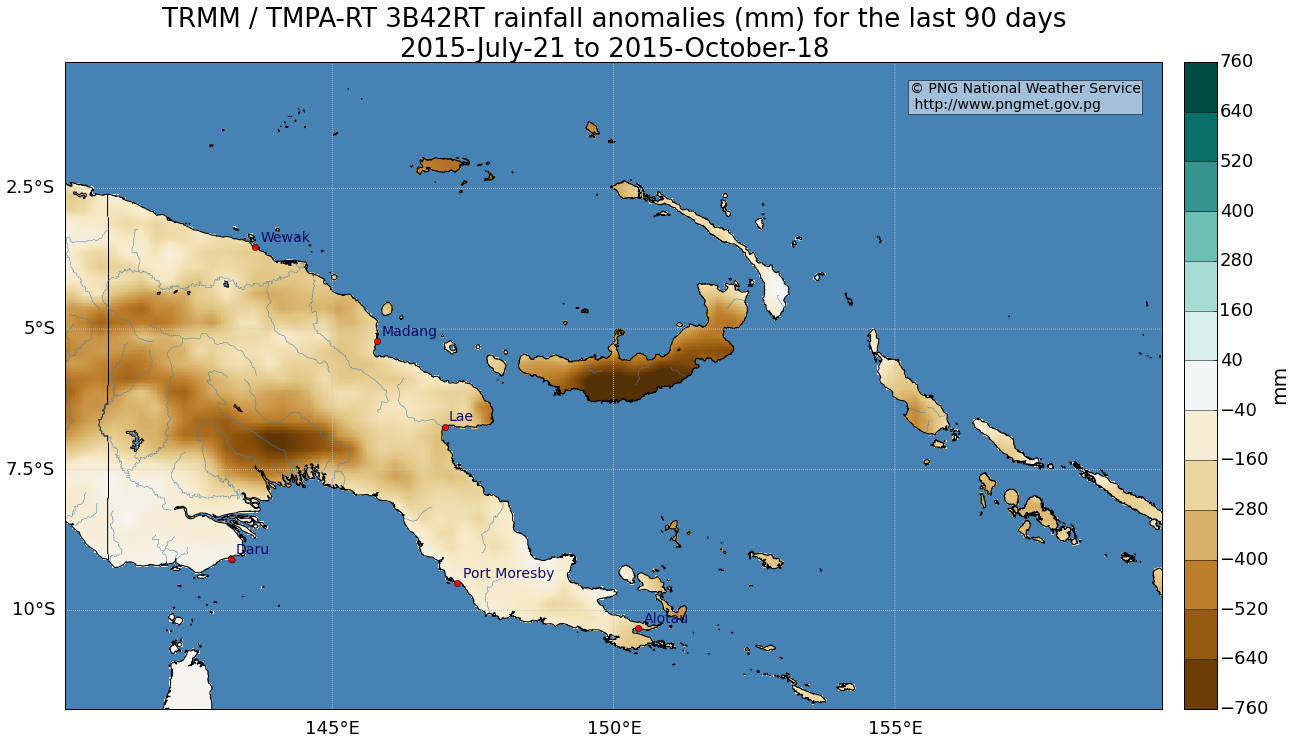

In [241]:
f = plot_map(m, anoms, title=title, units='mm', draw_cities=True, cmap=cmap_anoms)

In [242]:
f.savefig('../images/last{}days_maskocean_anoms_mm.png'.format(ndays), dpi=200)

In [243]:
title = 'TRMM / TMPA-RT 3B42RT rainfall (% normal) for the last {} days\n{:%Y-%B-%d} to {:%Y-%B-%d}'\
.format(ndays, realtime[0],realtime[-1])

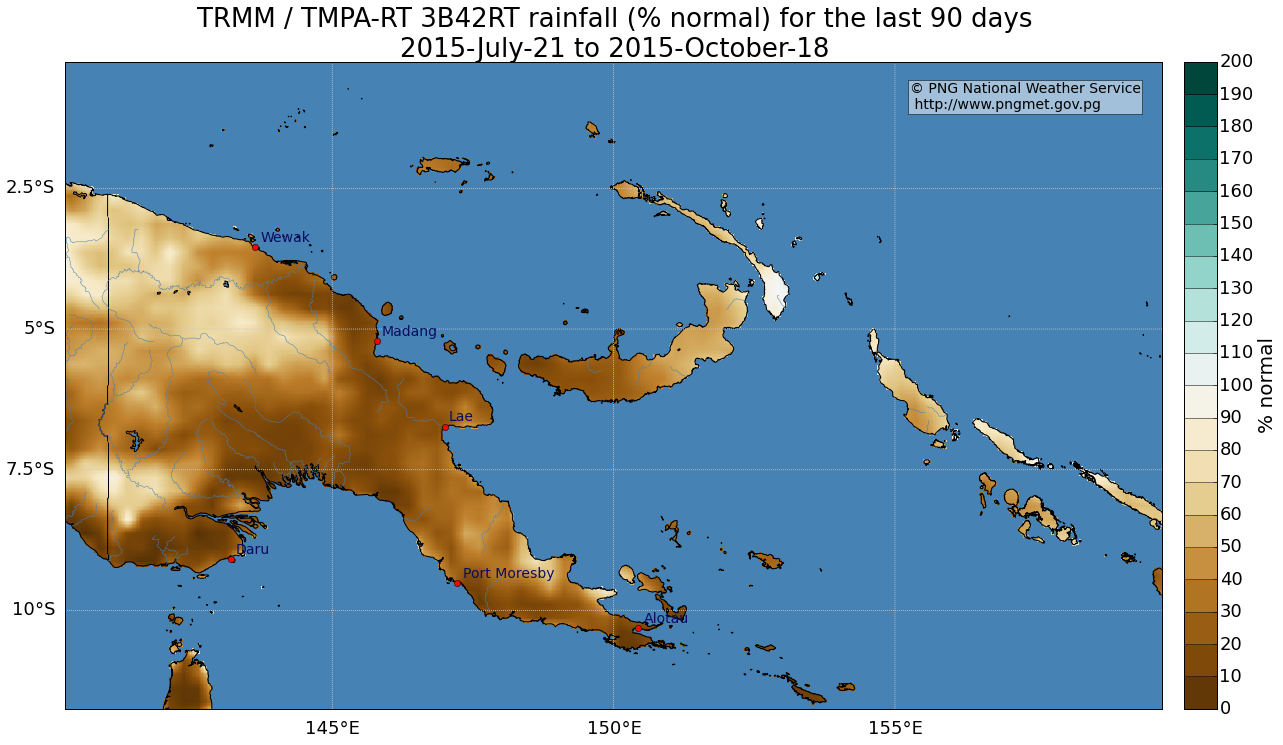

In [244]:
f = plot_map(m, pp, vmin=0, vmax=200, step=10, title=title, units='% normal', draw_cities=True, cmap=cmap_anoms)

In [245]:
f.savefig('../images/last{}days_maskocean_anoms_percent_normal.png'.format(ndays), dpi=200)

In [246]:
title = 'TRMM / TMPA-RT 3B42RT rainfall anomalies (percent. point) for the last {} days\n{:%Y-%B-%d} to {:%Y-%B-%d}'\
.format(ndays, realtime[0],realtime[-1])

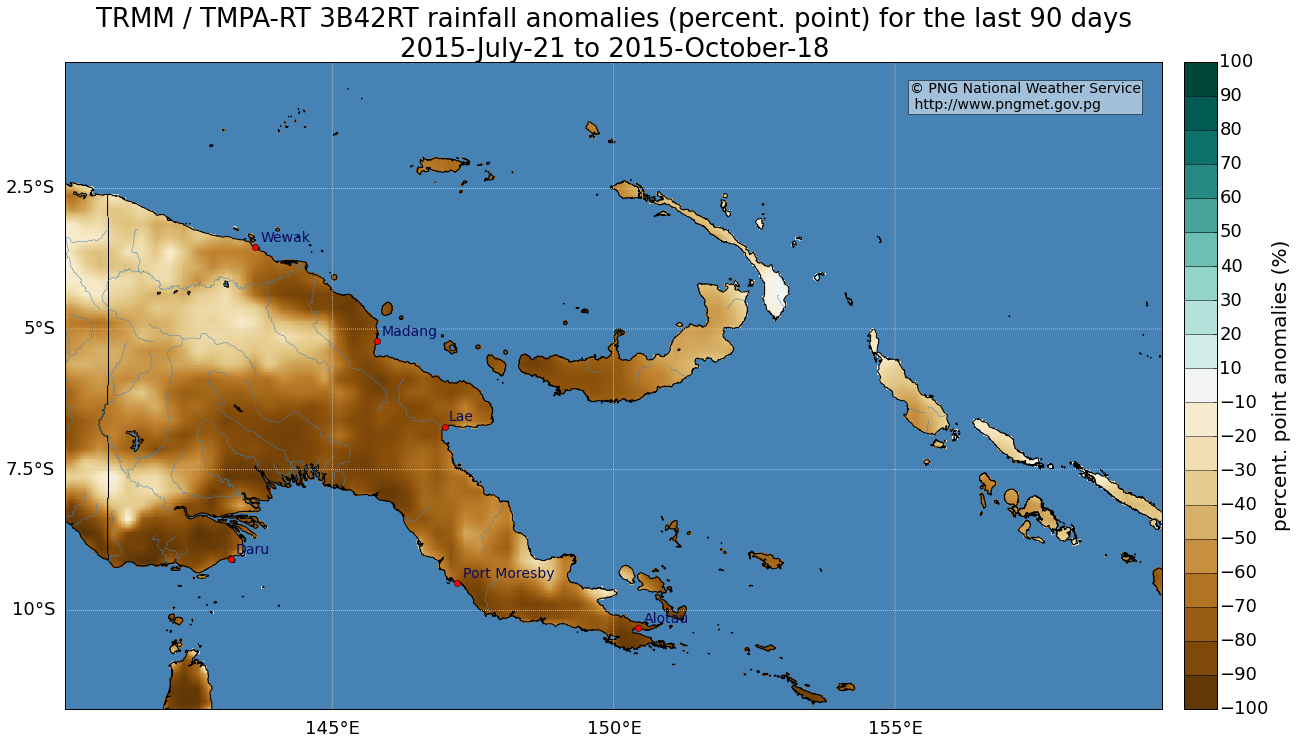

In [247]:
f = plot_map(m, anomsp, title=title, units='percent. point anomalies (%)', draw_cities=True, cmap=cmap_anoms)

In [248]:
f.savefig('../images/last{}days_maskocean_anoms_pp.png'.format(ndays), dpi=200)

In [249]:
# dset_realtime.close()
# dset_clim.close()

In [273]:
cities['Madang'] = (-5.216667, 145.8)

In [274]:
cities['Madang'][0]

-5.216667

In [367]:
lat_V = cities['Madang'][0]
lon_V = cities['Madang'][1]
# lat_V = -5
# lon_V = 142.5



In [368]:
clim_ts = dset_clim.sel(latitude=lat_V, longitude=lon_V, method='nearest')['hrf']

In [369]:
realtime_ts = dset_realtime.sel(lat=lat_V, lon=lon_V, method='nearest')['trmm']

In [370]:
realtime_ts.lat.data

array(-5.125, dtype=float32)

In [371]:
df_ts = realtime_ts.to_dataframe()[['trmm']]

In [372]:
df_ts.loc[:,'clim'] = clim_ts.data

In [373]:
df_ts.columns = ['observed','climatology']

In [380]:
for loc, coords in cities.items():
    lat_V = coords[0]
    lon_V = coords[1]
    
    clim_ts = dset_clim.sel(latitude=lat_V, longitude=lon_V, method='nearest')['hrf']
    realtime_ts = dset_realtime.sel(lat=lat_V, lon=lon_V, method='nearest')['trmm']
    df_ts = realtime_ts.to_dataframe()[['trmm']]
    df_ts.loc[:,'clim'] = clim_ts.data
    df_ts.columns = ['observed','climatology']
    

    f, ax = plt.subplots(figsize=(12,6))
    df_ts['climatology'].plot(kind='area', color='g', alpha=0.5, ax=ax, label='climatology')
    df_ts['observed'].plot(kind='area', color='b', alpha=0.6, ax=ax, label='observed')

    # df_ts.plot(kind='area', color=['g','b'], alpha=0.6, ax=ax)

    ax.legend(fontsize=18)

    ax.set_ylim(0,df_ts.max().max())

    [l.set_fontsize(18) for l in ax.xaxis.get_majorticklabels()]
    [l.set_fontsize(18) for l in ax.xaxis.get_minorticklabels()];
    [l.set_fontsize(18) for l in ax.yaxis.get_majorticklabels()]


    ax.set_xlabel("")
    ax.set_ylabel("mm", fontsize=18)

    ax.grid('on')

    ax.set_title('TRMM / TMPA_RT 3B42RT Virtual Station: LAT: {}, LON: {}'\
                 .format(realtime_ts.lat.data, realtime_ts.lon.data), fontsize=19)
    f.savefig('../images/Virtual_Station_{}.png'.format(loc), dpi=200)
    plt.close(f)

In [357]:
df_ts.max().max()

39.33000183105469